In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def show_image(title, image, cmap=None):
    plt.figure(figsize=(12, 8))
    plt.imshow(image if cmap is None else image, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

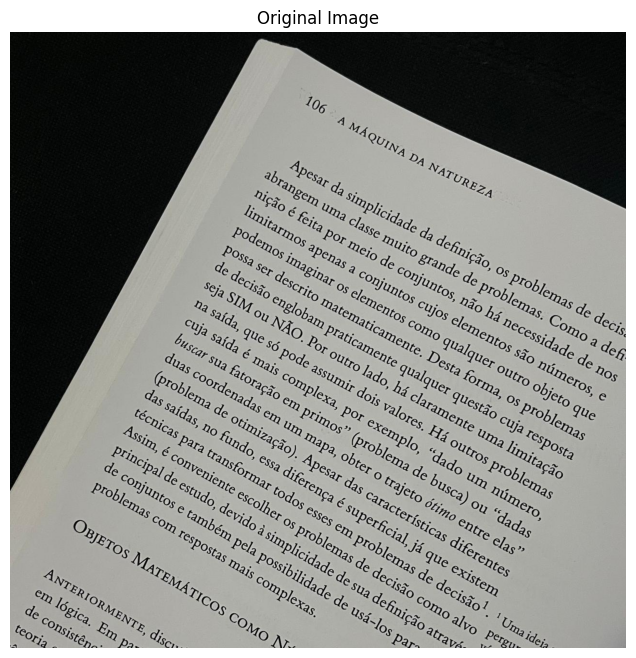

In [2]:
img_path = "livro.jpeg"
orig = cv2.imread(img_path)
image = orig.copy()
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image("Original Image", image_rgb)

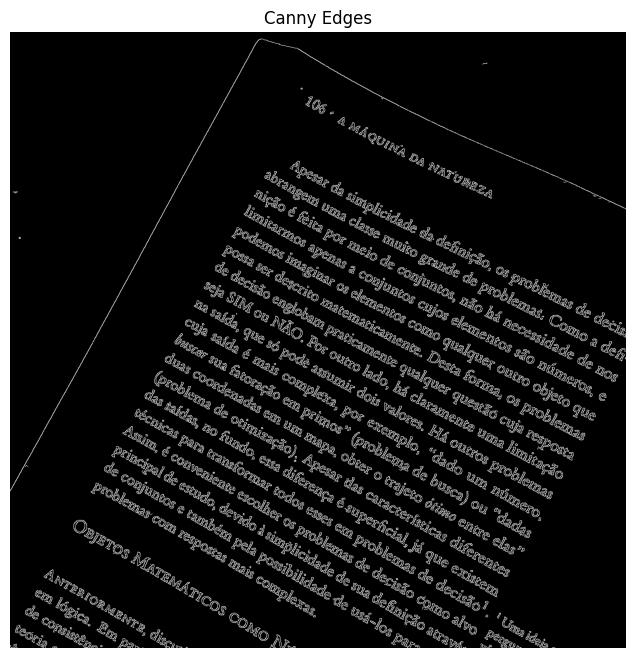

In [ ]:
# Converte a imagem RGB para tons de cinza
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplica o algoritmo Canny para detecção de bordas
# O Canny é um detector de bordas multi-estágio conhecido por sua robustez.
# 50 e 150 são os valores de limiar (threshold) para o Canny.
# Bordas com gradiente maior que 150 são consideradas bordas fortes.
# Bordas com gradiente entre 50 e 150 são consideradas bordas se estiverem conectadas a bordas fortes.

edges = cv2.Canny(gray, 50, 150, apertureSize=3)
show_image("Canny Edges", edges, cmap="gray")

In [ ]:
# Detecta linhas na imagem de bordas usando a Transformada de Hough.
# Cada linha é retornada como (rho, theta).
lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=200)

In [ ]:
# Extrai e normaliza os ângulos das linhas para o intervalo [-90, 90] graus.
angles = np.array([line[0][1] for line in lines])
degrees = (angles * 180 / np.pi) % 180
degrees[degrees > 90] -= 180  # center angles at 0
degrees = degrees.reshape(-1, 1)

In [ ]:
# Agrupa as linhas em 2 clusters (horizontais/verticais) usando K-Means nos ângulos.
kmeans = KMeans(n_clusters=2, random_state=0).fit(degrees)
labels = kmeans.labels_

In [ ]:
# Encontra as 4 linhas mais externas (min/max rho por cluster de ângulo) que definem os cantos.

lines_arr = np.array([line[0] for line in lines])  # (rho, theta)
corners = []
for lbl in [0, 1]:
    subset = lines_arr[labels == lbl]
    rhos = subset[:, 0]
    thetas = subset[:, 1]
    for rho in [rhos.min(), rhos.max()]:
        idx = np.argmin(np.abs(rhos - rho))
        theta = thetas[idx]
        a, b = np.cos(theta), np.sin(theta)
        corners.append((rho, a, b))

In [ ]:
# função para encontrar o ponto de interseção de duas linhas.
def intersect(line1, line2):
    rho1, a1, b1 = line1
    rho2, a2, b2 = line2
    A = np.array([[a1, b1], [a2, b2]])
    b = np.array([rho1, rho2])
    return np.linalg.solve(A, b)

In [ ]:
# Calcula os 4 pontos de canto (top-left, bottom-left, top-right, bottom-right)
tl = intersect(corners[0], corners[3])
bl = intersect(corners[0], corners[2])
tr = intersect(corners[1], corners[3])
br = intersect(corners[1], corners[2])
pts = np.array([tl, tr, br, bl], dtype=np.float32)

In [ ]:
# Calcula a largura e altura da imagem corrigida.
width = int(np.linalg.norm(tr - tl))
height = int(np.linalg.norm(bl - tl))
dst = np.array(
    [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], 
    dtype=np.float32
)

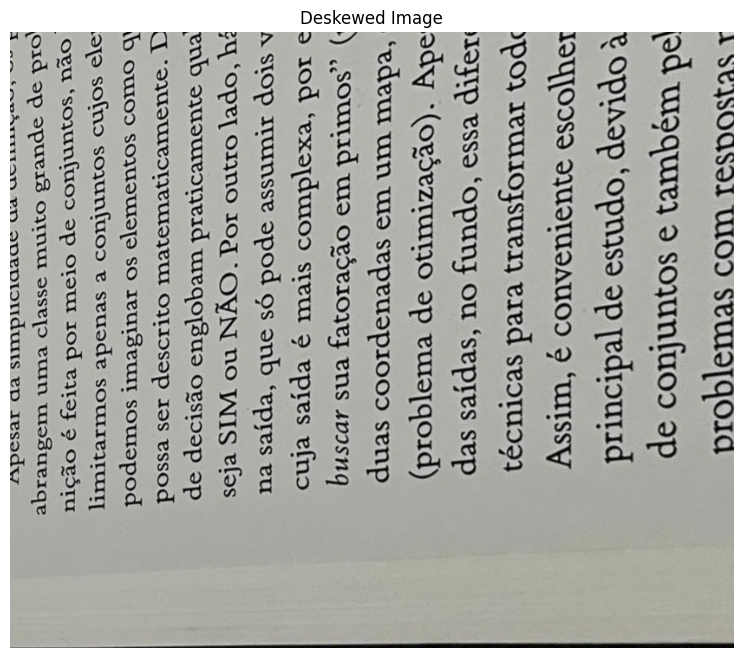

In [11]:
M = cv2.getPerspectiveTransform(pts, dst)
deskewed = cv2.warpPerspective(orig, M, (width, height))
deskewed_rgb = cv2.cvtColor(deskewed, cv2.COLOR_BGR2RGB)
show_image("Deskewed Image", deskewed_rgb)

In [12]:
deskewed_horizontal = cv2.rotate(deskewed, cv2.ROTATE_90_CLOCKWISE)

# Show both versions for comparison
deskewed_rgb_vertical = cv2.cvtColor(deskewed, cv2.COLOR_BGR2RGB)
deskewed_rgb_horizontal = cv2.cvtColor(deskewed_horizontal, cv2.COLOR_BGR2RGB)

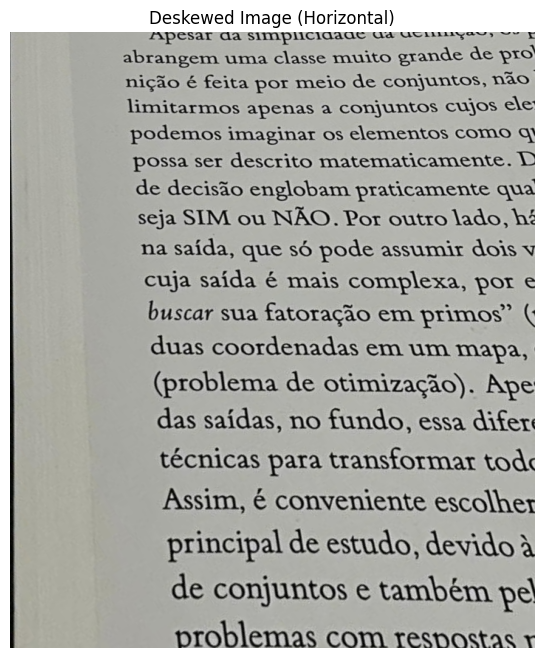

In [13]:
show_image("Deskewed Image (Horizontal)", deskewed_rgb_horizontal)